<h1 style="font-size:30px;">The Data</h1>

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [142]:
from tensorflow.keras.datasets import mnist

In [143]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

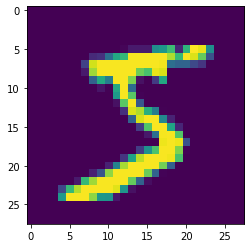

In [144]:
plt.imshow(x_train[0])

In [145]:
y_train[0] #so as we see above and below, the image shows "5".

5

## Filtering out the Data for Faster Training on Smaller Dataset

In [146]:
only_zeros = x_train[y_train==0] #images that only show "0"

In [147]:
only_zeros.shape

(5923, 28, 28)

In [148]:
x_train.shape

(60000, 28, 28)

In [149]:
#as we can see above, there are fewer images in "only_zeros", that can help reduce the length of the data we work with.

In [150]:
# plt.imshow(only_zeros[10])
# plt.imshow(only_zeros[13])

<h1 style="font-size:30px;">The Model</h1>


<h1 style="font-size:20px;">1) generator</h1>

In [151]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten

In [ ]:
#The GAN's "generator" is very much like Autoencoder's "decoder".
coding_size = 100 #so: 28*28=784 so: 784 --> 150 --> ? --> 150 --> 784 so: ?=100

generator = Sequential()

generator.add(Dense(100, activation = 'relu', input_shape = [coding_size])) #"Dense(100)"" doesn't have to be 100, but "input_shape = [coding_size]" should be 100.
generator.add(Dense(150, activation = 'relu'))
generator.add(Dense(784, activation = 'sigmoid'))

generator.add(Reshape([28, 28]))


<h1 style="font-size:20px;">2) discriminator</h1>

In [153]:
#A simple model without using CNN:
discriminator = Sequential()

discriminator.add(Flatten(input_shape = [28, 28]))
discriminator.add(Dense(150, activation = 'relu', input_shape = [28, 28]))
discriminator.add(Dense(100, activation = 'relu')) #we can add more Dense layers to make it harder for discriminator to "collapse".

discriminator.add(Dense(1, activation = 'sigmoid')) #1: because in a discriminator we "always" have a binary classification: fake or no. so we just need 1 output neuron.

discriminator.compile(optimizer = 'adam', loss = "binary_crossentropy") #we "compile" the discriminator, but not the generator.


<h1 style="font-size:20px;">3) GAN</h1>

In [154]:
GAN = Sequential([generator, discriminator])

In [155]:
discriminator.trainable = False #the "discriminator" should not be trained.

In [156]:
GAN.compile(loss = "binary_crossentropy", optimizer = 'adam')


<h1 style="font-size:20px;">create batches</h1>

In [157]:
batch_size = 32

In [158]:
my_dataset = only_zeros #or: x_train

In [159]:
#like what we do in NLP:

dataset = tf.data.Dataset.from_tensor_slices(my_dataset).shuffle(buffer_size = 1000) #buffer_size = 1000: is just a limit

In [160]:
# type(dataset)

In [161]:
dataset = dataset.batch(batch_size = batch_size, drop_remainder = True).prefetch(1)

In [162]:
# len(my_dataset) / batch_size #so "drop_remainder = True" will drop the remaider .09375

In [163]:
epochs = 1 #if at the end, the image by the generator was too noisy, then assign a larger number like 10 to the "epochs".

In [164]:
# GAN.layers
# GAN.layers[0].layers

# GAN.layers[0].summary() #generator
# GAN.layers[1].summary() #discriminator

In [165]:
# Grab the seprate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i = i + 1
        if i%100 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_dataset)//batch_size}")
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, coding_size])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, coding_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")            
    

Currently on Epoch 1
	Currently on batch number 100 of 185
TRAINING COMPLETE


In [166]:
noise = tf.random.normal(shape = [10, coding_size]) #shape = [number of fake images, coding_size]

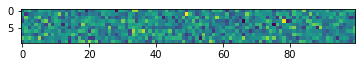

In [167]:
plt.imshow(noise)

In [168]:
images = generator(noise)

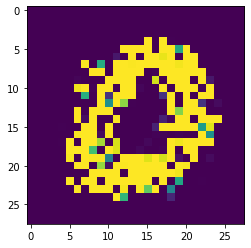

In [169]:
plt.imshow(images[0])

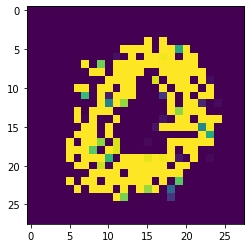

In [170]:
plt.imshow(images[1])

In [171]:
#mode collapse has occured! :(

In [ ]:
#The solution is: DCGAN!